# Problem Set 1 (20 + 40 + 30 = 90 points)

## Important information
1.  We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

2.  Please submit the single Jupyter Notebook file, where only Python and Markdown/$\LaTeX$ are used. Any hand-written solutions inserted by photos or in any other way **are prohibitive and will not be graded**. If you will have any questions about using Markdown, ask them!
3.  The works will be checked for **plagiarism**. The score will be divided by the number of similar works.

4. Some tasks in this assignment are bonus. It means that you can get maximum score for this assignment even if you ignore these tasks. However, if you get $y$ points for bonus tasks and $x$ points for regular tasks, then your score for the assignment will be $\min(90, x+y)$. If $x + y > 90$, then we will label your submission and take into account in the final grade releasing (e.g. in the border case).

## Problem 1. QR backpropagation (20 pts)

Our goal is to write an orthogonalization layer, that for an arbitrary rectangular matrix $A$ produces an orthonormal matrix $Q$ and (optionally) an upper triangualr matrix $R$ such that $A = QR$. 
In other words, we need to compute the QR decomposition.

There are problems when one need to optimize over orthogonal matrices, so using such layer can be a solution.

A standard algorithm to compute the QR decomposition is the Gram-Schmidt process.
For the linearly independent set of vectors $a_1,\dots,a_n$ (that are defined with the matrix $A$) it computes matrix $Q$ that contains orthonormalized set of vectors $q_1,\dots,q_n$.

This algorithm is listed below.

$$
\begin{split}
u_1 &= v_1, \\
u_2 &= v_2 - \frac{(v_2, u_1)}{(u_1, u_1)} u_1, \\
\dots \\
u_n &= v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}.
\end{split}
$$

Obtained $u_1, \dots, u_n$ are orthogonal vectors in exact arithmetics. Then to make the system orthonormal you should divide each of the vectors by its norm: $u_i := u_i/\|u_i\|$.

We have $A = QR$. 
Matrix $Q$ consists of vectors $u_1, \dots, u_n$. 
Now let's look at the matrix $R$. 

$Q^*A = R$. 
So $R_{i, j} = (u_i, v_j)$ (assuming $u_i$ is already normalized). 
And it is exactly what we see in Gram-Schmidt algorithm:

$$ v_n = \frac{(v_n, u_1)}{(u_1, u_1)} u_1 + \frac{(v_n, u_2)}{(u_2, u_2)} u_2 + \dots + \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1} + u_n.$$ 

This is the representation of vectors $v_i$ in our newly computed ortonormal basis. 
Thus they form matrix $R$. 
These coefficients are in the upper triangular part of $R$, because when $i>j$ we get $R_{i j} = 0$, because then we get sum of scalar products of orthogonal vectors. 

There is a more [computationally stable version of the Gram-Schmidt algorithm](https://en.wikipedia.org/wiki/Gram–Schmidt_process#Numerical_stability) that reduces the loss of orthogonality in matrix $Q$. 
This algorithm is called the modified Gram-Schmidt algorithm.

The loop of orthogonalization is the same, except for the computing the vector $u_k$ simultaneously:

$$ u_n = v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}
u_n$$

$$ 
 = v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1},
$$

one need to iteratively update $u_k$ step-by-step for a better numerical stability.

$$
\begin{split}
u_k &= v_k - \frac{(v_k, u_1)}{(u_1, u_1)} u_1, \\
u_k &= u_k - \frac{(u_k, u_2)}{(u_2, u_2)} u_2, \\
\dots \\
u_k &= u_k - \frac{(u_k, u_{k-1})}{(u_{k-1}, u_{k-1})} u_{k-1}. \\
\end{split}
$$


You are supposed to do the following tasks:

__1.__ (2 points) Implement the modified Gram-Schmidt algorithm in a function ```modified_gram_schmidt(A)``` using PyTorch.

__2.__ (1 point) Create a random matrix $A \in \mathbb{R}^{m \times n}$, $m \gg n$. For the arbitrary loss function, eg. $L(Q) = \sum_{i=0}^{m-1}\sum_{j=0}^{n-1} q_{ij}$, compute the gradient $\frac{\partial L}{\partial Q}$. Finally, compute $\frac{\partial L}{\partial A}$ using built-in PyTorch backpropagation through your implementation of QR decomposition (```modified_gram_schmidt(A)```).

__3.__ (2 points) Compute gradient $\frac{\partial L}{\partial A}$ using backpropagation through built-in PyTorch function for computing QR decomposition.

In [ ]:
# install dependencies
!pip install memory-profiler
import torch

def modified_gram_schmidt(A):
    """
    Computes QR decomposition of matrix A
    
    Input: 
        A - m x n matrix
    Output:
        Q - m x n orthonormal matrix
        R - n x n upper triangular matrix
    """
    Q = A.clone()
    for i in range(A.size(1)):
        for j in range(i):
            new_mat = torch.zeros_like(Q)
            new_mat[:, i] = torch.dot(Q[:, i], Q[:, j]) / torch.dot(Q[:, j], Q[:, j]) * Q[:, j]
            Q = Q - new_mat
    
    Q = Q / torch.linalg.norm(Q, dim=0)
    
    R = torch.matmul(Q.T, A)
    R = torch.triu(R)
    return Q, R

m = 100
n = 20
A = torch.rand((m, n), requires_grad=True)

# Your code is below
Q1, R1 = torch.linalg.qr(A) # torch version
Q2, R2 = modified_gram_schmidt(A) # modified_gram_schmidt

loss1 = Q1.sum()
loss2 = Q2.sum()


# TODO compute gradients
loss1.backward()
print('torch', A.grad)
A.grad.zero_()
loss2.backward()
print('modified', A.grad)
print()
print('For torch built-in function, ||A-QR|| =', torch.linalg.norm(A - torch.matmul(Q1, R1)).item(), '||Q^TQ - I|| =',
      torch.linalg.norm(torch.eye(Q1.size(-1)) - torch.matmul(Q1.T, Q1)).item())
print('For custom realization, ||A-QR|| =', torch.linalg.norm(A - torch.matmul(Q2, R2)).item(), '||Q^TQ - I|| =',
      torch.linalg.norm(torch.eye(Q2.size(-1)) - torch.matmul(Q2.T, Q2)).item())

Defaulting to user installation because normal site-packages is not writeable



torch tensor([[ 0.1144, -0.0059, -0.1532,  ...,  0.0076,  0.0041, -0.0089],

        [ 0.1564, -0.0693, -0.1189,  ..., -0.0041,  0.0237, -0.0345],

        [-0.1705, -0.1292, -0.0916,  ..., -0.0099, -0.0056,  0.0031],

        ...,

        [ 0.1928, -0.0273, -0.0625,  ..., -0.0365, -0.0706,  0.0771],

        [-0.1002, -0.2642, -0.2995,  ...,  0.1122,  0.1165, -0.0838],

        [ 0.1247,  0.0076, -0.0392,  ..., -0.0070, -0.0123,  0.0253]])

modified tensor([[-0.4182, -0.3041, -0.1570,  ...,  0.0210,  0.0072,  0.0089],

        [-0.4428, -0.3089, -0.1857,  ...,  0.0279,  0.0280,  0.0345],

        [ 0.1372,  0.0588,  0.0644,  ..., -0.0038, -0.0025, -0.0031],

        ...,

        [-0.3374, -0.1450, -0.0774,  ..., -0.0629, -0.0624, -0.0771],

        [-0.3456, -0.2828, -0.1674,  ...,  0.0389,  0.0673,  0.0838],

        [-0.1872, -0.0473, -0.0163,  ..., -0.0434, -0.0206, -0.0253]])



For torch built-in f

__4.__ (13 points total) Write the backpropagation $\frac{\partial L}{\partial A}$ from scratch with PyTorch. Do not forget to use ```requires_grad=False``` to disable PyTorch autograd accumulation of the gradient.

  a) (2 points) Derive analytically the gradient $\frac{\partial y}{\partial x}$ of vector normalization operation $y := x/\|x\|$.

  b) (1 point) Implement backward through the vector normalization operation (can be implemented either in the function ```backward_normalization``` or further inside the code).

  c) (2 points) Derive analytically the gradient $\frac{\partial u_k}{\partial v_j}$ of the othonormalization operation:

$$
\begin{split}
u_k &= v_k - \frac{(v_k, u_1)}{(u_1, u_1)} u_1, \\
u_k &= u_k - \frac{(u_k, u_2)}{(u_2, u_2)} u_2, \\
\dots \\
u_k &= u_k - \frac{(u_k, u_{k-1})}{(u_{k-1}, u_{k-1})} u_{k-1}. \\
\end{split}
$$

  d) (2 points) Implement backward through the othonormalization operation (can be implemented either in the function ```backward_orthogonalization``` or further inside the code).

  e) (1 point) Implement the QR forward pass (almost identically to ```modified_gram_schmidt```, but with storing the additional data nesessary for backpropagation) with the method ```forward``` of class ```QR``` (see template below).

  f) (5 points) Implement the QR backward pass using previously implemented functions and place it in the method ```backward``` of class ```QR```  (see template below).

__5.__ (2 points) Look at obtained $Q$ and $R$ matrices for each approach (steps 2, 3, 4), verify that $A \approx QR$ and $Q^TQ \approx I$. Measure the required memory for backpropagation (eg. with ```memory_profiler```). 
Compare the results of three approaches: 

- gradient from the PyTorch built-in function
- gradient from PyTorch autograd applied to your function ```modified_gram_schmidt```
- your custom implementation of backward step from analytical expressions. 

Compare the theoretical asymptotics of the memory usage for the backpropagation of the modified Gram-Schmidt algorithm with every approach listed above. 
What data is needed for backpropagation and thus affects the memory consumption?

### Your solution
4.a)
$$\frac{\partial y}{\partial x} = \frac{\partial \frac{x}{\|x\|}}{\partial x} = \frac{\partial \frac{x}{\sqrt{x^Tx}}}{\partial x} =\frac{1}{\sqrt{x^Tx}} \frac{\partial x}{\partial x} + x \frac{\partial}{\partial x} \frac{1}{\sqrt{x^Tx}} = \frac{1}{\sqrt{x^Tx}} I + x \frac{-1}{2}\frac{2x^T}{(x^Tx)^{3/2}} = \frac{1}{\sqrt{x^Tx}}(I - \frac{xx^T}{x^Tx})$$

4.c)
We have sequence of substractions: $u^1_k = v_k - \frac{(v_k, u_1)}{(u_1, u_1)}u_1$,  $u^2_k = u^1_k - \frac{(u^1_k, u_2)}{(u_2, u_2)}u_2$, ..., $u^{k-1}_k = u^{k-2}_k - \frac{(u^{k-2}_k, u_{k-1})}{(u_{k-1}, u_{k-1})}u_{k-1}$, $u^{k-1}_k = u_k$

If k < j:
$$\frac{\partial u_k}{\partial v_j} = O$$
because $u_k$ doesn't depend on $v_j$.

If k = j:
$$\frac{\partial u_k}{\partial v_k} = \frac{\partial u^{k-1}_k}{\partial v_k} = \frac{\partial u^{k-2}_k}{\partial v_k} - \frac{u_{k-1} u_{k-1}^T}{(u_{k-1}, u_{k-1})}\frac{\partial u^{k-2}_k}{\partial v_k} = (I - \frac{u_{k-1}u_{k-1}^T}{(u_{k-1}, u_{k-1})})\frac{\partial u^{k-2}_k}{\partial v_k} = (I - \frac{u_{k-1}u_{k-1}^T}{(u_{k-1}, u_{k-1})}) (I - \frac{u_{k-2}u_{k-2}^T}{(u_{k-2}, u_{k-2})})\frac{\partial u^{k-3}_k}{\partial v_k}= ... = \prod\limits_{i=1}^{k-1}(I-\frac{u_{k-i}u_{k-i}^T}{(u_{k-i}, u_{k-i})})$$
Due to the fact that $u_i^Tu_j=0$, we have:
$$\prod\limits_{i=1}^{k-1}(I-\frac{u_{k-i}u_{k-i}^T}{(u_{k-i}, u_{k-i})}) = I - \sum\limits_{i=1}^{k-1}\frac{u_iu_i^T}{(u_i, u_i)}$$

If k > j:
$$\frac{\partial u_k}{\partial v_j} = \frac{\partial u^{k-1}_k}{\partial v_j}$$
Let's look at $u_k^{k-1} = u_k^{k-2} - \frac{(u^{k-2}_k, u_{k-1})}{(u_{k-1}, u_{k-1})}u_{k-1}$. Here, $(u^{k-2}_k, u_{k-1}) = (u^{k-3}_k - \frac{(u^{k-3}_k, u_{k-2})}{(u_{k-2}, u_{k-2})}u_{k-2}, u_{k-1}) = (u^{k-3}_k, u_{k-1}) - \frac{(u^{k-3}_k, u_{k-2})}{(u_{k-2}, u_{k-2})}(u_{k-2}, u_{k-1}) = (u^{k-3}_k, u_{k-1}) = ... = (v_k, u_{k-1})$ So we have $u_k^{k-1} = u_k^{k-2} - \frac{(v_k, u_{k-1})}{(u_{k-1}, u_{k-1})}u_{k-1}$. Thus:
$$\frac{\partial u^{k-1}_k}{\partial v_j} = \frac{\partial u_k^{k-2}}{∂ v_j} - \frac{(v_k, u_{k-1})}{(u_{k-1}, u_{k-1})} \frac{∂ u_{k-1}}{∂ v_j} - \frac{u_{k-1}v_k^T}{(u_{k-1}, u_{k-1})}\frac{∂ u_{k-1}}{∂ v_j} + 2\frac{(v_k, u_{k-1})}{(u_{k-1}, u_{k-1})^2}u_{k-1}u_{k-1}^T \frac{\partial u_{k-1}}{\partial v_j} = \frac{\partial u_k^{k-2}}{∂ v_j} + (-\frac{(v_k, u_{k-1})}{(u_{k-1}, u_{k-1})}I - \frac{u_{k-1}v_k^T}{(u_{k-1}, u_{k-1})} + 2\frac{(v_k, u_{k-1})}{(u_{k-1}, u_{k-1})^2}u_{k-1}u_{k-1}^T)\frac{\partial u_{k-1}}{\partial v_j}$$
By analogy, we can find $\frac{\partial u_k^{k-2}}{∂ v_j} = \frac{\partial u_k^{k-3}}{∂ v_j} + (-\frac{(v_k, u_{k-2})}{(u_{k-2}, u_{k-2})}I - \frac{u_{k-2}v_k^T}{(u_{k-2}, u_{k-2})} + 2\frac{(v_k, u_{k-2})}{(u_{k-2}, u_{k-2})^2}u_{k-2}u_{k-2}^T)\frac{\partial u_{k-2}}{\partial v_j}$ and so on. Also, we can notice: $\frac{\partial u_k^{i}}{∂ v_j} = 0$, if i < j. Therefore:
$$\frac{\partial u_k}{\partial v_j} = \sum\limits_{m=j}^{k-1}(-\frac{(v_k, u_{m})}{(u_{m}, u_{m})}I - \frac{u_{m}v_k^T}{(u_{m}, u_{m})} + 2\frac{(v_k, u_{m})}{(u_{m}, u_{m})^2}u_{m}u_{m}^T)\frac{\partial u_{m}}{\partial v_j}$$


In [ ]:
%load_ext memory_profiler

In [ ]:
%%file myQR.py
import torch
from memory_profiler import profile

def backward_normalization(x):
    scalar = torch.dot(x, x)
    outer = torch.outer(x, x)
    return (torch.eye(x.size(-1)) - outer / scalar) / torch.sqrt(scalar)

def backward_orthogonalization(Q, A):
    u_u_scalars = torch.diagonal(torch.matmul(Q.T, Q))
    u_v_scalars = torch.matmul(A.T, Q)

    u_u_outers = torch.cat([torch.outer(Q[:, i], Q[:, i]) for i in range(Q.size(-1))], dim=0).reshape(Q.size(-1), Q.size(0), -1)
    u_v_outers = [[torch.outer(Q[:, m], A[:, j]) for j in range(A.size(-1))] for m in range(Q.size(-1))]

    jacobians = {}
    for j in range(A.size(-1)):
        for k in range(j, Q.size(-1)):
            if k == j:
                jacobians[(k, j)] = torch.eye(Q.size(0)) - torch.sum(u_u_outers[:k] / u_u_scalars[:k].reshape(k, 1, 1), 0)
            else:
                jacobian = torch.zeros((Q.size(0), Q.size(0)))
                for m in range(j, k):
                    multiplier = (-u_v_scalars[k, m]  * torch.eye(Q.size(0)) - u_v_outers[m][k] + 2 * u_v_scalars[k, m] / u_u_scalars[m] * u_u_outers[m]) / u_u_scalars[m] 
                    jacobian += torch.matmul(multiplier, jacobians[(m, j)])
                jacobians[(k, j)] = jacobian

    return jacobians

class QR():
    def forward(self, A):
        """
        Computes QR decomposition of matrix A

        Input: 
            A - n x m matrix
        Output:
            Q - n x m orthonormal matrix
            R - m x m upper triangular matrix
        """
        Q = A.clone()
        for i in range(A.size(1)):
            for j in range(i):
                new_mat = torch.zeros_like(Q)
                new_mat[:, i] = torch.dot(Q[:, i], Q[:, j]) / torch.dot(Q[:, j], Q[:, j]) * Q[:, j]
                Q = Q - new_mat
        
        self.Q = Q
        self.A = A

        Q = Q / torch.linalg.norm(Q, dim=0)
        
        R = torch.matmul(Q.T, A)
        R = torch.triu(R)
        return Q, R
        

    def backward(self, grad_output):
        """
        Computes QR decomposition of matrix A

        Input: 
            grad_output - n x m matrix, derivative of the previous layer (derivative of loss dL/dQ  in our case)
        Output:
            grad_input - n x m derivative dL/dA
        """
        grad_input = torch.zeros_like(grad_output)
        self.backward_orthogonal = backward_orthogonalization(self.Q, self.A)

        for j in range(self.A.shape[1]):
            for k in range(j, self.A.shape[1]):
                grad = torch.matmul(grad_output[:, j], backward_normalization(self.Q[:, k]))
                grad_input[:, j] += torch.matmul(grad, self.backward_orthogonal[(k, j)])
         
        return grad_input

@profile
def torch_built_in(A):
    Q, R = torch.linalg.qr(A)
    loss = Q.sum()
    loss.backward()
    return A.grad

@profile
def myqr_autograd(A):
    qr = QR()
    Q, R = qr.forward(A)
    loss = Q.sum()
    loss.backward()
    return A.grad

@profile
def myqr(A):
    qr = QR()
    Q, R = qr.forward(A)
    loss = Q.sum()
    dL_dQ = torch.ones_like(Q)
    return qr.backward(dL_dQ)
    

Overwriting myQR.py


In [ ]:
from myQR import *

qr = QR()
A = torch.rand((m, n))

Q, R = qr.forward(A)
loss1 = Q.sum()

# TODO compute losses and do backpropagation
# compute dL / dQ and finally dL / dA
dL_dQ = torch.ones_like(Q)
dL_dA = qr.backward(dL_dQ)


A_autograd = A.clone().detach().requires_grad_(True)
Q_autograd, R_autograd = qr.forward(A_autograd)
loss2 = Q_autograd.sum()
loss2.backward()
print('Difference between gradients:', float(torch.linalg.norm(dL_dA - A_autograd.grad)))

Difference between gradients: 1.0913050573435612e-05


In [ ]:
print('For QR forward, ||A-QR|| =', torch.linalg.norm(A - torch.matmul(Q, R)).item(), '||Q^TQ - I|| =',
      torch.linalg.norm(torch.eye(Q.size(-1)) - torch.matmul(Q.T, Q)).item())

For QR forward, ||A-QR|| = 1.912869993248023e-05 ||Q^TQ - I|| = 2.2903943772689672e-06


In [ ]:
A1 = torch.rand((m, n), requires_grad=True)
torch_built_in(A1)
pass

Filename: /home/bogdan/skoltech/dl/myQR.py



Line #    Mem usage    Increment  Occurrences   Line Contents


    77    344.9 MiB    344.9 MiB           1   @profile

    78                                         def torch_built_in(A):

    79    344.9 MiB      0.0 MiB           1       Q, R = torch.linalg.qr(A)

    80    344.9 MiB      0.0 MiB           1       loss = Q.sum()

    81    344.9 MiB      0.0 MiB           1       loss.backward()

    82    344.9 MiB      0.0 MiB           1       return A.grad






In [ ]:
A2 = A1.clone().detach().requires_grad_(True)
myqr_autograd(A2)
pass

Filename: /home/bogdan/skoltech/dl/myQR.py



Line #    Mem usage    Increment  Occurrences   Line Contents


    84    344.9 MiB    344.9 MiB           1   @profile

    85                                         def myqr_autograd(A):

    86    344.9 MiB      0.0 MiB           1       qr = QR()

    87    345.0 MiB      0.1 MiB           1       Q, R = qr.forward(A)

    88    345.0 MiB      0.0 MiB           1       loss = Q.sum()

    89    345.0 MiB      0.0 MiB           1       loss.backward()

    90    345.0 MiB      0.0 MiB           1       return A.grad






In [ ]:
A3 = A2.clone().detach()
myqr(A3)
pass

Filename: /home/bogdan/skoltech/dl/myQR.py



Line #    Mem usage    Increment  Occurrences   Line Contents


    92    345.0 MiB    345.0 MiB           1   @profile

    93                                         def myqr(A):

    94    345.0 MiB      0.0 MiB           1       qr = QR()

    95    345.0 MiB      0.0 MiB           1       Q, R = qr.forward(A)

    96    345.0 MiB      0.0 MiB           1       loss = Q.sum()

    97    345.0 MiB      0.0 MiB           1       dL_dQ = torch.ones_like(Q)

    98    362.3 MiB     17.3 MiB           1       return qr.backward(dL_dQ)






As we can see, my implementation use additional 17.3 megabytes, but overall memory consumption is the same. Since we compute $\frac{\partial u_i}{\partial v_j}$, which is of size m by m, so assymptotic for memory is $O(n^2m^2)$. 

### Bonus tasks

__6.__ (10 points) Modify the previous code to be memory-efficient. 

Hint: not all intermediate variables need to be stored for backpropagation.

__7.__ (3 points) Again, measure the required memory for backpropagation. Explain the theoretical asymptotics of the memory usage for the memory-efficient backpropagation.

In [ ]:
# Your solution is here

## Problem 2. Voice classification (40 pts)

In this assigment you will have a chance to develop a voice-anti-spoofing algorithm, enhancing your skills in standard PyTorch classificaton development pipeline.

There are several types of attack: 
- replay attacks, when one records and repeats someone's voice, 
- impresario attacks, when the speaker mimics the target's voice like an actor and 
- the most interesting are deepfake attack, based on text-to-speech, voice cloning and voice conversion algorithms. 

In this work we will focus on deepfake attack and try to differ them from genuine (or bona-fide) speech.

We will use data, provided by organisers of biannual [ASVspoof](https://www.asvspoof.org/) contest. More precisely, we will take subpart `ASVspoof_2019LA` dataset, which consist of 17 different attacks DF attack types and bona-fide. All recordings were augmented to be close to real telephone recordings. We will not take 2021 data, but if you want, you can use 2021 data as test and 2019 data as train and validation.

The initital dataset can be downloaded from [here](https://datashare.ed.ac.uk/handle/10283/3336). However, we [provide you smaller subsample](https://drive.google.com/drive/folders/1-CyCFA3komqrtyoYj21y5gzfh_vcKBYx?usp=share_link) of dev (val) and eval (test) parts to make work in colab relatively possible :) . You can download it locally or put into you Drive. You will need around 3GB free space, think about creating a new account if you don't have enough.

We encourage you to look through data [overview](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_evaluation_plan.pdf?sequence=1&isAllowed=y) and result summary [paper](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_Interspeech2019_submission.pdf?sequence=2&isAllowed=y).

One important thing to notice: main application of this algorithms is in voice-biometry, when we want to stop illegal intruder. Thus, there are two (or 3) common ways of developing VAS algorithms: speaker-aware, we we train verification model which is sensitive to spoofing and differs bona-fide and impostor or we combinde verification score and score of VAS model to decide, whetherr the person is the same, and finally simple and general countermeasures setup, when given audio and model should predict whether it is a spoof or bona-fide. We will work on the last setup.

**Important: feel free not to use pre-defined functions, you can solve the task as you wish or change functions/pipelines significantly.** 

#### Preparations
It is a good practice to log and check you experiments. In this assignemnt, we ask you to sign up in wandb, log your experiments and give us a link to your project and attach plots/report in the notebook with your solution.

In [1]:
!pip install wandb

import copy
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import IPython.display as ipd
from typing import Optional
import torch
import torch.nn as nn
import torchaudio
# import librosa
import sklearn.metrics as metrics
import wandb
from torchvision.models import resnet50, resnet18
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


In [4]:
# https://wandb.ai/quickstart

!wandb login afd2f41e97270f1230f5ef5c144e6e80d9947695 # and paste your API key from https://wandb.ai/authorize

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
wandb.init(project="voice-anti-spoofing", name = "test_run", tags = ["SmallModel", "LA"])
SEED = 42  # do not change it
# mount drive if you wish

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

In [8]:
!ls for_collab

ASVspoof2019_LA_cm_protocols  README.LA.txt  flac_dev  flac_eval  train_flac


In [9]:
# to make dataframes
path_la_train = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
path_la_dev = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
path_la_eval = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

flac_la_train = "for_collab/train_flac/"
flac_la_dev = "for_collab/flac_dev/"
flac_la_eval = "for_collab/flac_eval/"

In [10]:
columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
df = pd.read_csv(path_la_train, sep=" ", header=None)
df.columns = columns
df.head()

,speaker_id,audio_file_name,system_id,skip,class
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [11]:
def makedf_ultimate(txt_file_path, flac_path, dataset_name='ASVspoof', data_type='LA', year=2019):
    
    if dataset_name=='ASVspoof':
        name = dataset_name+str(year)+data_type
        if data_type=='DF':
            attack_name = 'deepfake'
        elif data_type=='LA':
            attack_name = 'deepfake'
        else:
            attack_name = 'replay'
            
        df = pd.read_csv(txt_file_path, sep=" ", header=None)

            
        if year == 2019:
            df.columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
            df['dataset'] = name
            di = {'bonafide':0, 'spoof':1} # assign classes

            df['class'] = df['class'].map(di)
            # m = df['class'] == 0
            # df.loc[m, 'attack'] = 'noattack'
            df['audio_path'] = flac_path + df['audio_file_name'] + '.flac'
            df = df[["speaker_id", "audio_path", "class"]]
        
    # df = df[['audio_path', 'class', 'dataset', 'attack']]
    df = df[["speaker_id", "audio_path", "class"]]
    df = df.reset_index(drop=True)
    return df

In [12]:
df_train = makedf_ultimate(path_la_train, flac_la_train, year=2019, data_type='LA')
df_dev = makedf_ultimate(path_la_dev, flac_la_dev, year=2019, data_type='LA')
df_eval = makedf_ultimate(path_la_eval, flac_la_eval, year=2019, data_type='LA')

In [13]:
print('Train dataset labels: bonafide number -', len(df_train[df_train['class'] == 0]), ', spoof number -', len(df_train[df_train['class'] == 1]))
print('Dev dataset labels: bonafide number -', len(df_dev[df_dev['class'] == 0]), ', spoof number -', len(df_dev[df_dev['class'] == 1]))
print('Eval dataset labels: bonafide number -', len(df_eval[df_eval['class'] == 0]), ', spoof number -', len(df_eval[df_eval['class'] == 1]))

Train dataset labels: bonafide number - 2580 , spoof number - 22800
Dev dataset labels: bonafide number - 2548 , spoof number - 22296
Eval dataset labels: bonafide number - 7355 , spoof number - 63882


**Task 1.1 (2 points)** Check data distribution. Is it imbalanced? How are you going to deal with it?

Hints: upsampling, downsampling, add new data, e.g. from this [source](https://commonvoice.mozilla.org/) (but will new audios have the same distribution?), or adjust loss functions.

**Answer**

As we can see from above, spoofed audios outnumbered bonafide. Classical approach for binary unbalanced classes - use appropriate loss, for example weighted cross-entropy. Or we can use oversampling.

In [14]:
# for dev and eval, let's simplify the task and use smaller amount of data, but balanced to better understand metrics
# we need this functions, because it removes unuploaded data from our dataframes
def balanced_split(df):
    k = min(len(df[df['class']==0]), len(df[df['class']==1]))
    print(k)
    df_bf = df[df['class']==0].sample(frac=1, random_state=SEED).iloc[0:k]
    df_spoof = df[df['class']==1].sample(frac=1, random_state=SEED).iloc[0:k]

    df_bf = df_bf.append([df_spoof], ignore_index=True)
    df_bf = df_bf.reset_index(drop=True)
    return df_bf

df_eval = balanced_split(df_eval)
df_dev = balanced_split(df_dev)

7355
2548


In [15]:
# for audio manipulations we advise you to use torchaudio or librosa
x, sr = torchaudio.load(df_eval["audio_path"].iloc[0])

In [16]:
ipd.display(ipd.Audio(x, rate=sr))

**Task 1.2. (1 point)** Display several spoof and bona-fide audios. Can you hear the difference?

In [17]:
print('spoofed voices:')
for ind in [10, 120, 200]:
    x, sr = torchaudio.load(df_eval[df_eval['class'] == 1]["audio_path"].iloc[ind])
    ipd.display(ipd.Audio(x, rate=sr))

print('bonafide voices:')
for ind in [10, 120, 200]:
    x, sr = torchaudio.load(df_eval[df_eval['class'] == 0]["audio_path"].iloc[ind])
    ipd.display(ipd.Audio(x, rate=sr))

spoofed voices:


bonafide voices:


I cannot distinguish bonafide and spoofed voices, they sound similar to me. Maybe except second spoofed voice, it sounds a little bit electronic.

### Custom dataset and Model

You can find inspiration and hints in 
- https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://pypi.org/project/audiomentations/ 
- https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html
- and any other blogposts about spectrograms

**Task 2.1 (5 points)** We can work with audios as with images, transforming into spectrograms. Here your task is to implement simple model, which receives raw wav (amplitudes, but probably already preprocced in dataset), transforms it into mel-spectrogram, changes amplitude to DB scale (if you want) and then procceses through the layers. You are free to use ready pre-trained backbones, e.g. from `torchvision.models` and fine-tune them. However, if you want to practise more, create something on your own. Large models with `requires_grad=True` for all parameters will probably result in problems on training in colab. 

In [18]:
from torchvision import models

class WavResNet(nn.Module):
    def __init__(self, classes=None, resample=16000, n_mels=80, melspec_config=None):
        super().__init__()
        if melspec_config is None:
            melspec_config ={'n_fft': 1024, 'win_length': None, 'hop_length': 512}
        
        self.fbank = torchaudio.transforms.MelSpectrogram(sample_rate=resample,
                                                          n_fft=melspec_config['n_fft'],
                                                          win_length=melspec_config['win_length'],
                                                          hop_length=melspec_config['hop_length'],
                                                          n_mels=n_mels,
                                                          mel_scale="htk")
        self.to_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude")
        
        model = models.resnet34(weights=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3, 3), bias=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, classes)
        self.network = model
        # or create your own layers and use them in forward pass
        
    
    def forward(self, x, wav_lens: Optional[torch.Tensor]=None):  # can check the length if you want. this is helpful for inference
        mels = self.fbank(x)
        mels_db = self.to_db(mels)
        out = self.network(mels_db)
        return out

**Task 2.2 (1 point)**
In your opinion, which approach is better for binary classification: 
- Model's last layer output has shape 1, train with BCE-like loss.
- Model's last layer output has shape 2, train with cross-entropy like loss. 

**Task 2.3 (3 points)** Create custom dataset, which recieves ```df``` and returns preprocessed audio.

**Task 2.4 (1 point)** Should we use augmentaions? If yes, which ones? 

**Task 2.2**

I think these approaches are same, because sigmoid of output for only one class is similar to corresponding output of softmax. $\frac{e^{p0}}{e^{p0}+e^{p1}} = \frac{1}{1+e^{p1-p0}}$

**Task 2.4**

Yes, augmentations may improve quality of our model and increase number of data, on which our model learn. So we can use TimeMasking and FrequencyMasking.

In [29]:
class DatasetWav(Dataset):

    def __init__(self, data_frame, padding_sec=4, default_sr=16000, transform=None):
        self.df = data_frame
        self.padding_sec = padding_sec
        self.default_sr = default_sr
        self.labels = data_frame['class']
        self.paths = data_frame['audio_path']
        self.transform = transform
        #self.vad = ...   # in this task you are free to ommit it in order to speed up calculations,
                         # also the provided data should be rather clean
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        label = self.labels[idx]
        path = self.paths[idx]
        waveform , sr = torchaudio.load(path, normalize=True) # normalize=True
        # transform waveform from stereo to mono channel 
        waveform = waveform.mean(dim=0)
        resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.default_sr) # should we use it for our data or can ommit? 
        waveform = resample_transform(waveform)
        # waveform = self.vad(waveform)

        # came up with idea, what to do if audio is longer or shorter than reuqired
        if (len(waveform) < self.padding_sec * self.default_sr):
            pad_size = (self.padding_sec * self.default_sr - len(waveform)) // 2
            x = nn.functional.pad(waveform, (pad_size, self.padding_sec * self.default_sr - len(waveform) - pad_size))
        else:
            x = waveform[:self.padding_sec * self.default_sr]
        
        x = x.reshape(1, -1)
        if not self.transform is None:
            x = self.transform(x)

        return x, label

In [20]:
# check that works
batch_size = 5
train_dataset_wavs = DatasetWav(df_train.iloc[0:200]) #.iloc[0:200]
train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=0)
x, y = next(iter(train_dataloader_wavs))
model = WavResNet(classes=2)
model(x)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

tensor([[ 0.7554,  0.3612],
        [ 0.2148,  0.5555],
        [ 0.8676, -0.6192],
        [ 0.2064,  0.4019],
        [ 1.6533,  0.3771]], grad_fn=<AddmmBackward0>)

### Train and Test functions
**Task 3.0 (1 point)** What is the difference between `model.train()` and `model.eval()`? Does `model.eval()` mode take gradient statisitcs into account?

**Answer**

Difference in these methods, that they switch modes of model. model.train() for training, and model.eval() for inference. It affects on performing of some layers, like BatchNorm or Dropout. model.eval() doesn't take into account gradient statistics, because in this mode model don't learning.

**Task 3.1 (5 points)** Implement train and test functions, which iterate over all batches. Do logging of loss, accuracy on each batch and after every epoch. Check equal error rate EER, explain, what is it.

**Answer**
EER is a measure of robustness of biometric system. The lower EER, the more reliable system is. EER is an error of equal error rates for errors of first and second types, in other words: of False Positive and False Negative. With appropriate threshold for considering whether object is zero or first class we can make them equal. Same value of FP and FN in this case is an EER. 

In [21]:
def calculate_eer(y, y_score):
    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)    
    return eer, thresh

In [22]:
def train(model, dataloaders, criterion, optimizer, 
          num_epochs=3, scheduler=None, savename=None,
          print_counter=10, decay_factor=10,
          device=torch.device("cuda")):

    epoch_loss = {'train': [], 'val': []}
    epoch_accuracy = {'train': [], 'val': []}

    for epoch in tqdm(range(num_epochs)):
        batch_loss = {'train': [], 'val': []}
        batch_accuracy = {'train': [], 'val': []}

        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            step = 0
            print(f'Epoch {epoch+1} of {phase} is running...')
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
            
                if not step % print_counter:
                    print(phase + ' loss is: {:.2f} batch_accuracy: {:.2f}'.format(loss.item(), torch.sum(preds == labels).item() / len(labels)))
                    if savename:
                        torch.save(model.state_dict(), savename + f'_{epoch}_' + f'_{step}_')

                batch_loss[phase].append(loss.item())
                batch_accuracy[phase].append(torch.sum(preds == labels.data).item())
                wandb.log({f'{phase} batch loss': loss.item(),
                           f'{phase} batch accuracy': torch.sum(preds == labels.data).item()})
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                step += 1
                
            if not scheduler is None:
                scheduler.step()

            wandb.log({f'{phase} epoch loss': running_loss / len(dataloaders[phase].dataset),
                        f'{phase} epoch accuracy': running_corrects / len(dataloaders[phase].dataset)})
            epoch_loss[phase].append(running_loss / len(dataloaders[phase].dataset))
            epoch_accuracy[phase].append(running_corrects / len(dataloaders[phase].dataset))
            print(phase + ' epoch {} loss is: {:.2f}'.format(epoch+1, running_loss / len(dataloaders[phase].dataset)),
                  'accuracy: {:.2f}'.format(running_corrects / len(dataloaders[phase].dataset)))

    if savename:
        torch.save(model.state_dict(), savename)

    return model, epoch_accuracy['val']

def test(model, test_dataloader, criterion=None, device=None, savename=None):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        y = []
        probs = []
        soft = nn.Softmax(dim=1)
        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            y.append(labels.cpu())
            prob = soft(outputs.cpu())
            probs.append(prob[:, 1])
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        
        print('Test loss is: {:.2f}'.format(running_loss / len(test_dataloader.dataset)))
        print('Test accuracy is: {:.2f}'.format(running_corrects / len(test_dataloader.dataset)))
    return torch.cat(y), torch.cat(probs)

### Main loop 

**Task 4.1 (3 points)** What loss will you choose and why? What it should receive for input (logits, probs)? Explain your answer.
Consider also:
- https://medium.com/swlh/focal-loss-what-why-and-how-df6735f26616
- https://libauc.org/


**Task 4.2 (5 points)** Implement main function, which receives yaml or json config (or path to it) and train and test the model, save model checkpoints, and model's test predictions. At least, you should obain results better than random. It is good, if accuracy on test dataset is >= 0.75.

**Task 4.1**
I will choose CrossEntropy loss, because it is supports weights for losses and it is more suitable for me. It can receive either logits or probs, so it is better to give logits for faster computations.

In [23]:
def main(config):
    lr = config['lr']
    epochs = config['epochs']
    batch_size = config['batch_size']
    wandb.init(project="voice-anti-spoofing", name = config['name'], tags = ["ResNet", "LA"])
    wandb.config = {
      "learning_rate": lr,
      "epochs": epochs,
      "batch_size": batch_size
    }

    
    # debug firstly on small subpart of dataset
    train_dataset_wavs = DatasetWav(config['train'], transform=config['transform']) #.iloc[0:200]
    train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataset_wavs = DatasetWav(config['val'])
    val_dataloader_wavs = DataLoader(val_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=2)
    test_dataset_wavs = DatasetWav(config['test'])
    test_dataloader_wavs = DataLoader(test_dataset_wavs, batch_size=batch_size, shuffle=False, num_workers=2)
    dataloaders = {"train": train_dataloader_wavs, "val": val_dataloader_wavs}
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classes = 2                                        
    model = WavResNet(classes)                                                                  
    model = model.to(device)
    # freeze layers except the last one if you want
    for param in model.parameters():
        param.requires_grad = False
    model.network.fc.requires_grad_(True)
    model.network.conv1.requires_grad_(True)
                                                                                           
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
    alpha = config['alpha']
    sc = torch.tensor([alpha, 1 - alpha]).to(device) # weights for loss
    criterion = nn.CrossEntropyLoss(weight=sc, label_smoothing=config['smooth'])
    
    for_ckpts = "."
    os.makedirs(for_ckpts, exist_ok=True)
    
    print("Start training:")
    model, val_acc_history = train(model, dataloaders, criterion, optimizer, 
          num_epochs=epochs, scheduler=scheduler, savename=for_ckpts + '/'+config['name'],
          print_counter=10, decay_factor=10,
          device=device)
    
    print()
    print("Start evaluating:")
    y, probs = test(model, test_dataloader_wavs, criterion=criterion,
                    device=device, savename=for_ckpts)
    
    return y, probs

config = {'lr': 0.001, 'epochs': 3, 'batch_size': 512, 'train': df_train, 
          'val': df_dev, 'test': df_eval, 
          'alpha': 0.85, 'smooth': 0, 'transform': None, 'name': 'base_model'}
y, probs = main(config)

Start training:


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.86 batch_accuracy: 0.70
train loss is: 0.64 batch_accuracy: 0.73
train loss is: 0.60 batch_accuracy: 0.68
train loss is: 0.57 batch_accuracy: 0.80
train loss is: 0.53 batch_accuracy: 0.74
train epoch 1 loss is: 0.59 accuracy: 0.76
Epoch 1 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 1.03 batch_accuracy: 0.61
val epoch 1 loss is: 1.02 accuracy: 0.61
Epoch 2 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.46 batch_accuracy: 0.83
train loss is: 0.43 batch_accuracy: 0.81
train loss is: 0.40 batch_accuracy: 0.81
train loss is: 0.41 batch_accuracy: 0.83
train loss is: 0.37 batch_accuracy: 0.79
train epoch 2 loss is: 0.40 accuracy: 0.84
Epoch 2 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.76 batch_accuracy: 0.73
val epoch 2 loss is: 0.76 accuracy: 0.73
Epoch 3 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.34 batch_accuracy: 0.83
train loss is: 0.35 batch_accuracy: 0.88
train loss is: 0.37 batch_accuracy: 0.82
train loss is: 0.33 batch_accuracy: 0.86
train loss is: 0.34 batch_accuracy: 0.90
train epoch 3 loss is: 0.32 accuracy: 0.87
Epoch 3 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.37 batch_accuracy: 0.86
val epoch 3 loss is: 0.36 accuracy: 0.87

Start evaluating:


  0%|          | 0/29 [00:00<?, ?it/s]

Test loss is: 0.00
Test accuracy is: 0.84


Training might require a long time. So, you can try to use subpart of the dataset to receive rather good results. Also, you don't have to train for many epochs, 1 or even a half of epoch might be enough. Also consider to make some speedups in the model and dataset.

Colab also might work unstable with lots of data. If this happens, think how to deal with it, e.g. restart the kernel and/or remove the majority of data from Drive and try to bugfix firstly, then do train and test separately. 



**Task 4.3 (5 points)** Analyze the results. Play some audios with wrong predictions. Plot prediction distributions vs class. Is it possible to find better threshold?

**Task 4.4 (5 points)** Discuss the results and your approaches + hyperparameters. If you can, run some experiments with different parameters.

 Write your ideas, what else you can try to improve the results in the future.

**Task 4.5 (3 points)** Provide link to wandb project, or link to report. Upload best model's weights to Drive and provide a link with access right.


In [24]:
eer, thr = calculate_eer(y, probs)
eer, thr

(0.16478585995911935, array(0.4434591))

In [25]:
preds = (probs > float(thr)).to(torch.int)
not_similar = (preds != y).detach().numpy()
zero_mistake = df_eval[not_similar & (df_eval['class'] == 0)]
one_mistake = df_eval[not_similar & (df_eval['class'] == 1)]

print('Bonafide mistakes')
for i in range(3):
    x, sr = torchaudio.load(zero_mistake.iloc[i]['audio_path'])
    ipd.display(ipd.Audio(x, rate=sr))
    
print('Spoof mistakes')
for i in range(3):
    x, sr = torchaudio.load(one_mistake.iloc[i]['audio_path'])
    ipd.display(ipd.Audio(x, rate=sr))

Bonafide mistakes


Spoof mistakes


We can hear, that audios sound similar to each other, they heavily distinguishible.

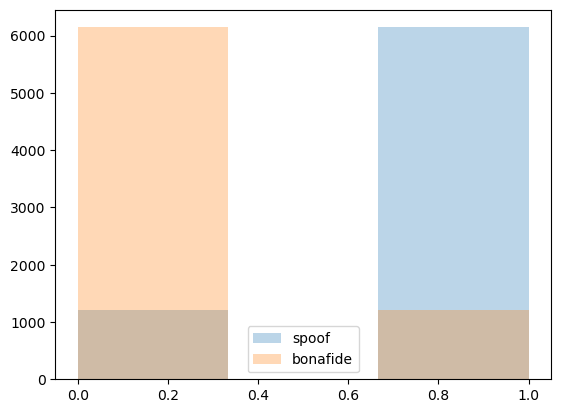

In [26]:
ones = preds[y == 1]
zeros = preds[y == 0]
plt.hist(ones, bins=3, alpha=0.3, label='spoof')
plt.hist(zeros, bins=3, alpha=0.3, label='bonafide')

plt.legend()
plt.show();

As we can see, using threshold from EER score we minimize errors from both classes. Thus I doubt if we can find better threshold.

**Task 4.4**

In [27]:
config = {'lr': 0.001, 'epochs': 3, 'batch_size': 512, 'train': df_train, 
          'val': df_dev, 'test': df_eval, 
          'alpha': 0.85, 'smooth': 0.1, 'transform': None, 'name': 'model_smooth'}
y, probs = main(config)

train batch accuracy,▂▅▅▅▇▅▆▆▆▆▆▆▇▁▆▇▆▇▇▇▇▇█▇▇▇▁▇██▇▇███▇███▂
train batch loss,██▆▆▆▆▆▅▅▅▅▄▄▃▄▄▃▃▄▃▃▃▂▃▃▃▃▂▂▂▂▃▂▂▂▁▁▂▂▁
train epoch accuracy,▁▆█
train epoch loss,█▃▁
val batch accuracy,▂▃▂▂▃▂▃▃▂▁▅▅▅▅▄▅▅▅▄▄▇██▇█████▆
val batch loss,█▇▇███▇███▅▄▅▆▅▅▅▅▆▆▂▁▁▂▁▁▁▂▁▂
val epoch accuracy,▁▄█
val epoch loss,█▅▁
train batch accuracy,262
train batch loss,0.24501
train epoch accuracy,0.8673


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training:


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.89 batch_accuracy: 0.56
train loss is: 0.74 batch_accuracy: 0.62
train loss is: 0.71 batch_accuracy: 0.71
train loss is: 0.67 batch_accuracy: 0.83
train loss is: 0.66 batch_accuracy: 0.81
train epoch 1 loss is: 0.72 accuracy: 0.69
Epoch 1 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.62 batch_accuracy: 0.75
val epoch 1 loss is: 0.59 accuracy: 0.77
Epoch 2 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.64 batch_accuracy: 0.83
train loss is: 0.60 batch_accuracy: 0.84
train loss is: 0.65 batch_accuracy: 0.77
train loss is: 0.64 batch_accuracy: 0.77
train loss is: 0.61 batch_accuracy: 0.80
train epoch 2 loss is: 0.63 accuracy: 0.80
Epoch 2 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.42 batch_accuracy: 0.80
val epoch 2 loss is: 0.42 accuracy: 0.81
Epoch 3 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.58 batch_accuracy: 0.81
train loss is: 0.61 batch_accuracy: 0.81
train loss is: 0.57 batch_accuracy: 0.87
train loss is: 0.61 batch_accuracy: 0.84
train loss is: 0.59 batch_accuracy: 0.86
train epoch 3 loss is: 0.60 accuracy: 0.83
Epoch 3 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.42 batch_accuracy: 0.86
val epoch 3 loss is: 0.43 accuracy: 0.84

Start evaluating:


  0%|          | 0/29 [00:00<?, ?it/s]

Test loss is: 0.00
Test accuracy is: 0.85


In [31]:
import random

def spec_augment(original_melspec,
                 freq_masking_max_percentage = 0.15, 
                 time_masking_max_percentage = 0.3):

    augmented_melspec = original_melspec.clone()
    all_frames_num, all_freqs_num = augmented_melspec.shape

    freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
    num_freqs_to_mask = int(freq_percentage * all_freqs_num)
    f0 = int(np.random.uniform(low = 0.0, high = (all_freqs_num - num_freqs_to_mask)))
    
    augmented_melspec[:, f0:(f0 + num_freqs_to_mask)] = 0

    time_percentage = random.uniform(0.0, time_masking_max_percentage)
    num_frames_to_mask = int(time_percentage * all_frames_num)
    t0 = int(np.random.uniform(low = 0.0, high = (all_frames_num - num_frames_to_mask)))
    
    augmented_melspec[t0:(t0 + num_frames_to_mask), :] = 0
    
    return augmented_melspec

config = {'lr': 0.001, 'epochs': 3, 'batch_size': 512, 'train': df_train, 
          'val': df_dev, 'test': df_eval, 
          'alpha': 0.85, 'smooth': 0, 'transform': spec_augment, 'name': 'model_augment'}
y, probs = main(config)

Start training:


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.87 batch_accuracy: 0.34
train loss is: 0.68 batch_accuracy: 0.74
train loss is: 0.57 batch_accuracy: 0.76
train loss is: 0.56 batch_accuracy: 0.76
train loss is: 0.52 batch_accuracy: 0.81
train epoch 1 loss is: 0.59 accuracy: 0.78
Epoch 1 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.76 batch_accuracy: 0.68
val epoch 1 loss is: 0.81 accuracy: 0.69
Epoch 2 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.46 batch_accuracy: 0.82
train loss is: 0.50 batch_accuracy: 0.81
train loss is: 0.43 batch_accuracy: 0.85
train loss is: 0.42 batch_accuracy: 0.81
train loss is: 0.46 batch_accuracy: 0.81
train epoch 2 loss is: 0.45 accuracy: 0.83
Epoch 2 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.62 batch_accuracy: 0.75
val epoch 2 loss is: 0.59 accuracy: 0.76
Epoch 3 of train is running...


  0%|          | 0/50 [00:00<?, ?it/s]

train loss is: 0.41 batch_accuracy: 0.83
train loss is: 0.37 batch_accuracy: 0.85
train loss is: 0.38 batch_accuracy: 0.87
train loss is: 0.42 batch_accuracy: 0.87
train loss is: 0.41 batch_accuracy: 0.82
train epoch 3 loss is: 0.41 accuracy: 0.84
Epoch 3 of val is running...


  0%|          | 0/10 [00:00<?, ?it/s]

val loss is: 0.64 batch_accuracy: 0.77
val epoch 3 loss is: 0.65 accuracy: 0.77

Start evaluating:


  0%|          | 0/29 [00:00<?, ?it/s]

Test loss is: 0.00
Test accuracy is: 0.76


For experiments I choosed to apply transformations and label-smoothing. As we can see, results not really improved. To train model properly one should choose appropriate alpha parameter for loss, because with low alpha I got really low results, almost random. And bigger batch_size and scheduler helped me increase score. For futher experiments we can vary alpha parameters, try more epochs, use another augmentations. Or try another architecture.

Wandb project: https://wandb.ai/bbg/voice-anti-spoofing?workspace=user-xiaomi1469

Weights of model: https://drive.google.com/file/d/1lMCyz2G6ow5gm5Ili6Q-3mhNJvLwcBwz/view?usp=sharing

**Bonus task. (50 points)** 

So far, we didn't care about speaker_id and verification. Take verification model from whatever you want and create counter measure subnetwork, as described in this [article](https://sasv-challenge.github.io/pdfs/2022_descriptions/IDVoice.pdf). Train the model, as described there. ASVspoof also provides Enrollment(anchor) recordings. Try to make blending, to obtain better metrics for counter measures.

These links might be helpful:
- https://github.com/archinetai/surgeon-pytorch
- https://www.kaggle.com/code/peter0749/additive-margin-softmax-loss-with-visualization

## Problem 3. (30 pts)

### Task 1 (10 pts)

For FCNN (Fully connected Neural Networks)
\begin{equation}
f(x)=f_k\left(f_{k-1}\left(\ldots\left(f_0(x)\right)\right),\right.
\end{equation}
assume the nonlinearity function $\sigma$ is ReLU and loss function $L$ is squared error loss function.
Prove that the deep learning model is not unique for any datasets, i.e. the optimization problem 
\begin{equation}
\min_\theta \ g(\theta)=\frac{1}{N} \sum_{i=1}^N L\left(y_i, \hat{y}_i\right), \text{where} \ \ \hat{y}_i=f\left(x_i, \theta\right),
\end{equation} 
dose not have an unique global minimizer $\theta$.

### Task 2 (5 pts)

The *softmax* activation function is 
\begin{equation}
\mathrm{Softmax}(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \ \text { for } \  i=1, \ldots, K \text { and } \mathbf{z}=\left(z_1, \ldots, z_K\right) \in \mathbb{R}^K.
\end{equation}
Suppose $\mathbf{z} \in \mathbb{R}^K$, and $\mathbf{a} \in \mathbb{R}^K$,
Prove that for the optimization problem
\begin{equation}
\begin{aligned}
& \min_{\mathbf{a}} \ -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle \\
& \text { s.t. } \sum_k^K \mathbf{a}_{k}=1,
\end{aligned}
\end{equation}
the minimizer is 
\begin{equation}
\mathbf{a}^*=\mathrm{Softmax}(\mathbf{z}).
\end{equation}

*Hint*: KKT optimality conditions and convexiy of the problem can help you to show the required equality

### Task 3 (15 pts)

For function $f(x)=x^2, x \in \left[0, 1\right]$, 

1) prove that the neural network $\hat f(x)$ based on the following structure has the approximation error 
\begin{equation}
|f(x)-\hat f(x)|\leq \frac{1}{2^{n-1}}
\end{equation}
where $n$ is the number of layers in the neural network.

![](https://github.com/oseledets/dl2023/blob/main/hw/hw1/neural_parabola.png?raw=1)

*Hint*: For each $ x \in \left[0, 1\right]$, $x$ can be denoted by its binary expansion $x=\sum_{i=0}^{∞} x_i/2^i$, where $x_i \in \{ 0, 1\}$. The above structure can be used to find $x_0,\dots, x_n$. Then we can write $\hat f(x)=f\left(\sum_{i=0}^{n} x_i/2^i\right).$

After the proof, if we want to achieve $\epsilon$ appoximation error based on the above neural network, the number of layers $n$ has to satisfy the condition $\frac{1}{2^{n-1}}\leq \epsilon$, i.e. $n\geq \log_2 \frac{1}{\epsilon}$.

2) Implement this neural network in any framework you like with different $n$ (for example $n = 3, 5, 10, 15$), and then plot the curve for absolute errors for different $n$. Compare the obtained plots with theoretical bound.


## Task1

We have FCNN with ReLU activations. Let's research, how it looks in terms of matrices:

$$f(x) = f_k(f_{k-1}(\ldots(f_0(x))) = relu(relu (relu(XW_1)W_2 )\ldots )W_k $$

ReLU function is $relu(x) = \begin{cases} 
x, \text{if}\ x > 0 \\
0, \text{otherwise}
\end{cases}$

We can see, that ReLU activation function is linear to positive multipliers, in other words: $$relu(\alpha x) = \alpha\ relu(x)$$ if $\alpha > 0$.

Thus, let's investigate two consecutive layers in our NN. Let's assume, that we have more than 1 layer, otherwise it will be a simple linear regression. In our FCNN we have:
$$\ldots relu(X_{i-1}W_{i-1}) W_i \ldots$$ 
where $X_{i-1}$ - input for i-th layer. It is easy to see, that $relu(X_{i-1}W_{i-1}) W_i$ are equal to $relu(X_{i-1}\frac{1}{\alpha}W_{i-1}) \alpha W_i = \frac{1}{\alpha} * \alpha\ relu(X_{i-1}W_{i-1})  W_i = relu(X_{i-1}W_{i-1}) W_i $, where $\alpha > 0$. 

Therefore, two NN with all equal weights, except those with indeces i and i-1, are produce same values, or in other words, are equal, if $W_i^1 = W_i, W_{i-1}^1=W_{i-1}, W_{i}^2=\alpha W_i, W_{i-1}^2=\frac{1}{\alpha} W_{i-1}$, where $W_i^1$ are weights of first NN, $W_i^2$ - of second.

So, if we have weights $\theta$, which is solution of problem $\min_\theta \ g(\theta)=\frac{1}{N} \sum_{i=1}^N L\left(y_i, \hat{y}_i\right)$, we always can find such $\hat{\theta}$, which is also solution of this problem, because $f(x, \theta) = f(x, \hat{\theta})$, as shown above. Thus, there is no unique minimizer for such problem.

## Task 2

$$\min_{\mathbf{a}} \ -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle \\
\text { s.t. } \sum_k^K \mathbf{a}_{k}=1$$
where $z, a \in \mathbb{R}^K$. Let's construct Lagrangian of this problem:
$$L(a, \lambda) = -a^Tz + a^T\log{a} + \lambda(\textbf{1}^Ta - 1)$$
KKT conditions:
$$\frac{∂ L}{∂ a} = -z + \log{a} + \textbf{1} + \lambda\textbf{1} = 0$$
$$\textbf{1}^Ta - 1 = 0$$
From first equation we derive: $\log{a} = z - \textbf{1} - \lambda \textbf{1} \to a = e^{z - \textbf{1} - \lambda \textbf{1}} = \frac{e^z}{e^{\textbf{1} + \lambda \textbf{1}}}$ - here it is elementwise function for vectors.

From second equation we get $\textbf{1}^T\frac{e^z}{e^{\textbf{1} + \lambda \textbf{1}}} - 1= \sum\limits_{k=1}^K \frac{e^{z_i}}{e^{1+\lambda}} - 1 = 0 \to \sum\limits_{k=1}^K \frac{e^{z_i}}{e^{1+\lambda}} = 1 \to \sum\limits_{k=1}^K e^{z_i} = e^{1+\lambda}$

Thus we obtain $a_i^* = \frac{e^{z_i}}{e^{1+\lambda}} = \frac{e^{z_i}}{\sum\limits_{k=1}^K e^{z_i}}$. So $\mathbf{a}^*=\mathrm{Softmax}(\mathbf{z})$ is a minimizer of this problem.

## Task 3

We have $f(x) = x^2$ and $\hat{f}(x) = (\sum\limits_{i=0}^n \frac{x_i}{2^i})^2$. Let's investigate error:
$$|f(x)-\hat f(x)| = |x^2 -  (\sum\limits_{i=0}^n \frac{x_i}{2^i})^2| = |(\sum\limits_{i=0}^\infty \frac{x_i}{2^i})^2 -  (\sum\limits_{i=0}^n \frac{x_i}{2^i})^2| = |(\sum\limits_{i=0}^\infty \frac{x_i}{2^i} - \sum\limits_{i=0}^n \frac{x_i}{2^i})(\sum\limits_{i=0}^\infty \frac{x_i}{2^i} + \sum\limits_{i=0}^n \frac{x_i}{2^i})|=|\sum\limits_{i=n+1}^\infty \frac{x_i}{2^i}||(\sum\limits_{i=0}^\infty \frac{x_i}{2^i} + \sum\limits_{i=0}^n \frac{x_i}{2^i})|$$
Here we can prove that:
$$\sum\limits_{i=n+1}^\infty \frac{x_i}{2^i} \leq \sum\limits_{i=n+1}^\infty \frac{1}{2^i} = \frac{1}{2^{n+1}}\sum\limits_{i=0}^\infty \frac{1}{2^i} = \frac{1}{2^{n+1}} * \frac{1}{1 - 1/2} = \frac{1}{2^n}$$
and
$$(\sum\limits_{i=0}^\infty \frac{x_i}{2^i} + \sum\limits_{i=0}^n \frac{x_i}{2^i}) \leq (\sum\limits_{i=0}^\infty \frac{x_i}{2^i} + \sum\limits_{i=0}^\infty \frac{x_i}{2^i}) = 2 \sum\limits_{i=0}^\infty \frac{x_i}{2^i} \leq 2$$
due to the fact that $x_i \in \{0, 1\}$ and $x \in [0, 1]$. So we have:
$$|f(x)-\hat f(x)| \leq \frac{1}{2^n} * 2 = \frac{1}{2^{n-1}}$$
End of a proof.

In [32]:
class MyNN(nn.Module):
    def __init__(self, n=3):
        super(MyNN, self).__init__()
        self.n = n

    def forward(self, x):
        assert x > 0
        assert x <= 1

        x_hat = self.approximate(x)
        return x_hat**2

    def approximate(self, x):
        x_hat = 0
        for i in range(self.n+1):
            binary_step = self.binary_step_unit(x - x_hat, i) * 1 / 2**i
            x_hat += binary_step
            
        return x_hat

    def binary_step_unit(self, x, n):
        return x >= 1 / 2**n

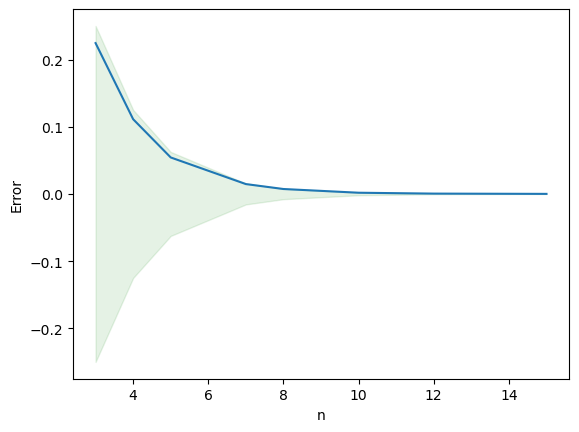

In [33]:
errors = []
ns = [3, 4, 5, 7, 8, 10, 12, 15]
upper_bound = [ 1/ 2**(i-1) for i in ns]
lower_bound = [-1/ 2**(i-1) for i in ns]

for n in ns:
    model = MyNN(n)
    curr_errors = []
    for x in torch.linspace(0.01, 1, 200):
        f_pred = model(x)
        f_true = x**2
        curr_errors.append(torch.abs(f_pred - f_true).item())
    errors.append(np.max(curr_errors))

plt.plot(ns, errors)
plt.fill_between(ns, lower_bound, upper_bound, color='g', alpha=.1)
plt.xlabel('n')
plt.ylabel('Error')
plt.show()

Empirical error is within theoretical boundaries.